In [27]:
import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
import json
from sklearn.model_selection import train_test_split

In [28]:
# ===============================
# Load Top-15000 ranked anime
# ===============================
DATA_DIR = "/kaggle/input"

top_folder = None
for p in glob.glob(os.path.join(DATA_DIR, "top-15000-ranked-anime-dataset-update-to-32025")):
    top_folder = p
    break

assert top_folder is not None, "❌ Không tìm thấy dataset top-15000"

csvs = glob.glob(os.path.join(top_folder, "**", "*.csv"), recursive=True)
top_csv = csvs[0]

print("Top-15000 CSV:", top_csv)

anime_df = pd.read_csv(top_csv)
print("Shape:", anime_df.shape)
anime_df.head()

Top-15000 CSV: /kaggle/input/top-15000-ranked-anime-dataset-update-to-32025/top_15000_anime.csv
Shape: (15000, 24)


,anime_id,anime_url,image_url,name,english_name,japanese_names,score,genres,themes,demographics,...,producers,studios,source,duration,rating,rank,popularity,favorites,scored_by,members
0,52991,https://myanimelist.net/anime/52991/Sousou_no_...,https://cdn.myanimelist.net/images/anime/1015/...,Sousou no Frieren,Frieren: Beyond Journey's End,葬送のフリーレン,9.29,"Adventure, Drama, Fantasy",NaN,Shounen,...,"Aniplex, Dentsu, Shogakukan-Shueisha Productio...",Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,1.0,128,76513,734207.0,1225468
1,5114,https://myanimelist.net/anime/5114/Fullmetal_A...,https://cdn.myanimelist.net/images/anime/1208/...,Fullmetal Alchemist: Brotherhood,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,9.10,"Action, Adventure, Drama, Fantasy",Military,Shounen,...,"Aniplex, Square Enix, Mainichi Broadcasting Sy...",Bones,Manga,24 min per ep,R - 17+ (violence & profanity),2.0,3,236798,2249670.0,3577489
2,9253,https://myanimelist.net/anime/9253/Steins_Gate,https://cdn.myanimelist.net/images/anime/1935/...,Steins;Gate,Steins;Gate,STEINS;GATE,9.07,"Drama, Sci-Fi, Suspense","Psychological, Time Travel",NaN,...,"Frontier Works, Media Factory, Kadokawa Shoten...",White Fox,Visual novel,24 min per ep,PG-13 - Teens 13 or older,3.0,14,198296,1483605.0,2737980
3,38524,https://myanimelist.net/anime/38524/Shingeki_n...,https://cdn.myanimelist.net/images/anime/1517/...,Shingeki no Kyojin Season 3 Part 2,Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,9.05,"Action, Drama, Suspense","Gore, Military, Survival",Shounen,...,"Production I.G, Dentsu, Mainichi Broadcasting ...",Wit Studio,Manga,23 min per ep,R - 17+ (violence & profanity),4.0,21,61832,1729484.0,2497671
4,28977,https://myanimelist.net/anime/28977/Gintama°,https://cdn.myanimelist.net/images/anime/3/720...,Gintama°,Gintama Season 4,銀魂°,9.05,"Action, Comedy, Sci-Fi","Gag Humor, Historical, Parody, Samurai",Shounen,...,"TV Tokyo, Aniplex, Dentsu",Bandai Namco Pictures,Manga,24 min per ep,PG-13 - Teens 13 or older,6.0,344,17315,266825.0,676352


In [29]:
before = len(anime_df)
anime_df = anime_df[~anime_df["genres"].str.contains("Hentai|Boys Love|Girls Love|Ecchi", case=False, na=False)]
print(f"Removed {before - len(anime_df)} hentai items")

Removed 2440 hentai items


In [30]:
def norm_col(c):
    return re.sub(r"[^a-z0-9]+", "_", c.strip().lower())

anime_df.columns = [norm_col(c) for c in anime_df.columns]

anime = pd.DataFrame({
    "anime_id": anime_df["anime_id"].astype(int),
    "title": anime_df["name"].astype(str),
    "image_url": anime_df["image_url"].astype(str),
    "anime_url": anime_df["anime_url"].astype(str),
    "score": pd.to_numeric(anime_df["score"], errors="coerce"),
    "members": pd.to_numeric(anime_df["members"], errors="coerce"),
    "genres": anime_df["genres"].astype(str)
})

anime = anime.dropna(subset=["anime_id", "title"])
anime.head()


,anime_id,title,image_url,anime_url,score,members,genres
0,52991,Sousou no Frieren,https://cdn.myanimelist.net/images/anime/1015/...,https://myanimelist.net/anime/52991/Sousou_no_...,9.29,1225468,"Adventure, Drama, Fantasy"
1,5114,Fullmetal Alchemist: Brotherhood,https://cdn.myanimelist.net/images/anime/1208/...,https://myanimelist.net/anime/5114/Fullmetal_A...,9.10,3577489,"Action, Adventure, Drama, Fantasy"
2,9253,Steins;Gate,https://cdn.myanimelist.net/images/anime/1935/...,https://myanimelist.net/anime/9253/Steins_Gate,9.07,2737980,"Drama, Sci-Fi, Suspense"
3,38524,Shingeki no Kyojin Season 3 Part 2,https://cdn.myanimelist.net/images/anime/1517/...,https://myanimelist.net/anime/38524/Shingeki_n...,9.05,2497671,"Action, Drama, Suspense"
4,28977,Gintama°,https://cdn.myanimelist.net/images/anime/3/720...,https://myanimelist.net/anime/28977/Gintama°,9.05,676352,"Action, Comedy, Sci-Fi"


In [31]:
# ===============================
# Load Option 1: Anime Recommendations Database
# ===============================
opt1_folder = None
for p in glob.glob(os.path.join(DATA_DIR, "anime-recommendations-database")):
    opt1_folder = p
    break

assert opt1_folder is not None, "❌ Không tìm thấy Option 1 dataset"

rating_csv = glob.glob(os.path.join(opt1_folder, "**", "rating.csv"), recursive=True)[0]

print("Rating CSV:", rating_csv)

ratings_df = pd.read_csv(rating_csv)
print("Shape:", ratings_df.shape)
ratings_df.head()


Rating CSV: /kaggle/input/anime-recommendations-database/rating.csv
Shape: (7813737, 3)


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [32]:
anime_ids = set(anime["anime_id"])
rating_ids = set(ratings_df["anime_id"])

print("Anime IDs (top15000):", len(anime_ids))
print("Anime IDs (ratings):", len(rating_ids))

overlap = anime_ids & rating_ids
print("Overlap anime_id:", len(overlap))
print("Overlap ratio:", len(overlap) / len(rating_ids))


Anime IDs (top15000): 12558
Anime IDs (ratings): 11200
Overlap anime_id: 7355
Overlap ratio: 0.6566964285714286


In [33]:
ratings_filt = ratings_df[ratings_df["anime_id"].isin(anime_ids)].copy()

print("Ratings after filter:", ratings_filt.shape)
ratings_filt.head()


Ratings after filter: (6506293, 3)


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
3,1,226,-1
5,1,355,-1
6,1,356,-1


In [34]:
merged = ratings_filt.merge(
    anime[["anime_id", "title", "genres", "image_url", "anime_url"]],
    on="anime_id",
    how="left"
)

merged.head()

,user_id,anime_id,rating,title,genres,image_url,anime_url
0,1,20,-1,Naruto,"Action, Adventure, Fantasy",https://cdn.myanimelist.net/images/anime/1141/...,https://myanimelist.net/anime/20/Naruto
1,1,24,-1,School Rumble,"Comedy, Romance",https://cdn.myanimelist.net/images/anime/1465/...,https://myanimelist.net/anime/24/School_Rumble
2,1,226,-1,Elfen Lied,"Action, Drama, Horror, Romance, Suspense",https://cdn.myanimelist.net/images/anime/1780/...,https://myanimelist.net/anime/226/Elfen_Lied
3,1,355,-1,Shakugan no Shana,"Action, Drama, Fantasy, Romance",https://cdn.myanimelist.net/images/anime/8/211...,https://myanimelist.net/anime/355/Shakugan_no_...
4,1,356,-1,Fate/stay night,"Action, Fantasy, Romance",https://cdn.myanimelist.net/images/anime/4/303...,https://myanimelist.net/anime/356/Fate_stay_night


In [35]:
# Create user and item index mapping
unique_users = merged["user_id"].unique()
unique_items = merged["anime_id"].unique()

user_to_idx = {u: i for i, u in enumerate(unique_users)}
item_to_idx = {a: i for i, a in enumerate(unique_items)}

idx_to_user = {i: u for u, i in user_to_idx.items()}
idx_to_item = {i: a for a, i in item_to_idx.items()}

print("Users:", len(user_to_idx))
print("Items:", len(item_to_idx))

Users: 73095
Items: 7355


In [36]:
rows = merged["user_id"].map(user_to_idx).to_numpy()
cols = merged["anime_id"].map(item_to_idx).to_numpy()

# implicit feedback
ratings = merged["rating"].to_numpy()
vals = np.where(ratings >= 7, 1.0, 0.0)

mask = vals > 0
rows, cols, vals = rows[mask], cols[mask], vals[mask]

R = sparse.coo_matrix(
    (vals, (rows, cols)),
    shape=(len(user_to_idx), len(item_to_idx))
).tocsr()

print("User–Item Matrix shape:", R.shape)
print("Non-zero entries:", R.nnz)


User–Item Matrix shape: (73095, 7355)
Non-zero entries: 4474571


In [37]:
# Sparsity
density = R.nnz / (R.shape[0] * R.shape[1])
print("Matrix density:", density)

# interactions per user
user_interactions = np.diff(R.indptr)
pd.Series(user_interactions).describe()


Matrix density: 0.008323022259150843


count    73095.000000
mean        61.215829
std         88.332792
min          0.000000
25%          8.000000
50%         30.000000
75%         79.000000
max       2031.000000
dtype: float64

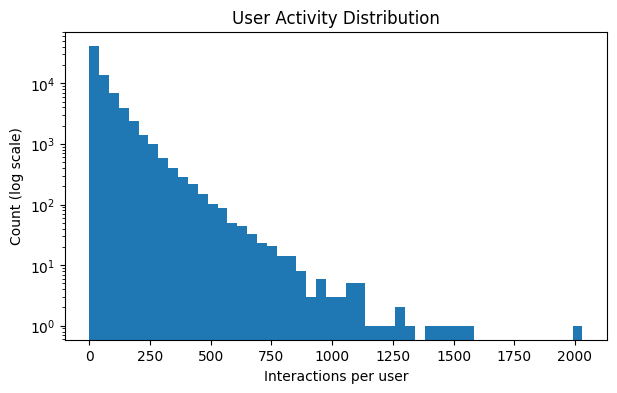

<Figure size 640x480 with 0 Axes>

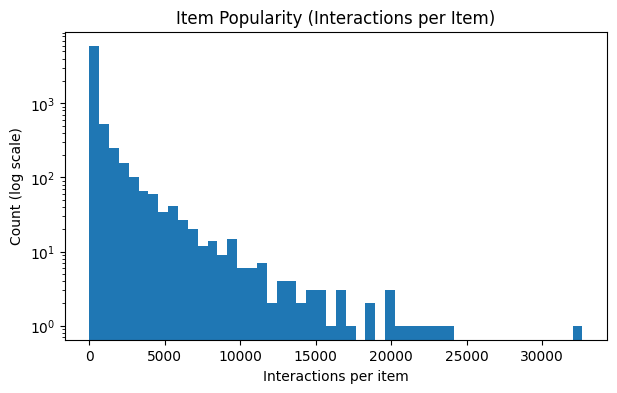

<Figure size 640x480 with 0 Axes>

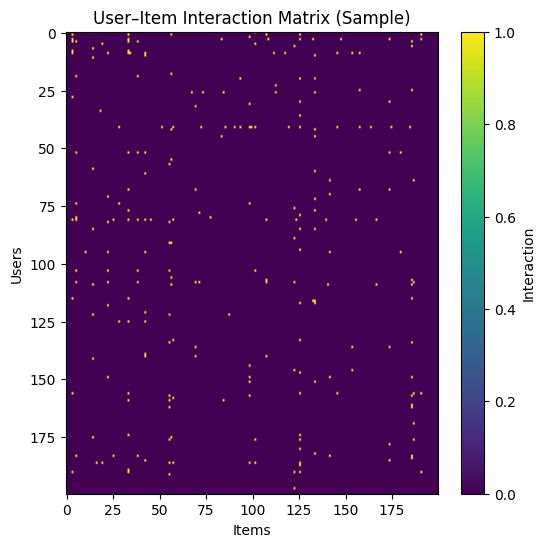

<Figure size 640x480 with 0 Axes>

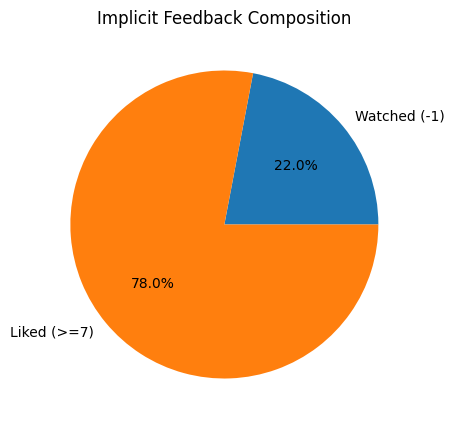

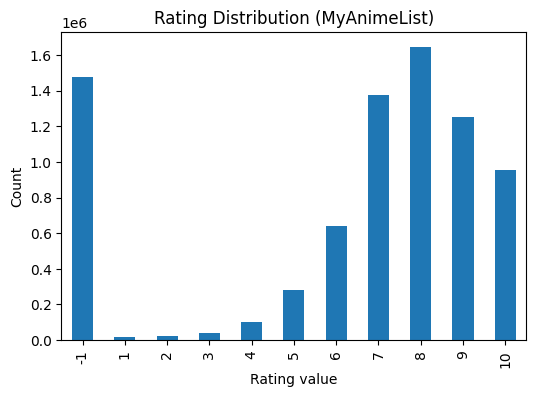

In [38]:
os.makedirs("artifacts/figures", exist_ok=True)
# A1. User activity distribution
plt.figure(figsize=(7, 4))
plt.hist(user_interactions, bins=50, log=True)
plt.title("User Activity Distribution")
plt.xlabel("Interactions per user")
plt.ylabel("Count (log scale)")
plt.show()
plt.savefig("artifacts/figures/user_activity_distribution.png", dpi=160)

# A2. Item popularity distribution
item_interactions = np.array(R.sum(axis=0)).ravel()

plt.figure(figsize=(7, 4))
plt.hist(item_interactions, bins=50, log=True)
plt.title("Item Popularity (Interactions per Item)")
plt.xlabel("Interactions per item")
plt.ylabel("Count (log scale)")
plt.show()
plt.savefig("artifacts/figures/item_popularity_distribution.png", dpi=160)


pd.Series(item_interactions).describe()
# A3. Sparsity pattern (sampled matrix)
np.random.seed(42)
u_idx = np.random.choice(R.shape[0], size=200, replace=False)
i_idx = np.random.choice(R.shape[1], size=200, replace=False)

R_sample = R[u_idx][:, i_idx].toarray()

plt.figure(figsize=(6, 6))
plt.imshow(R_sample > 0, aspect="auto")
plt.title("User–Item Interaction Matrix (Sample)")
plt.xlabel("Items")
plt.ylabel("Users")
plt.colorbar(label="Interaction")
plt.show()
plt.savefig("artifacts/figures/sparsity_pattern.png", dpi=160)

# A5b. Watched vs Liked ratio
watched = (ratings_df["rating"] == -1).sum()
liked = (ratings_df["rating"] >= 7).sum()

plt.figure(figsize=(5, 5))
plt.pie(
    [watched, liked],
    labels=["Watched (-1)", "Liked (>=7)"],
    autopct="%1.1f%%"
)
plt.title("Implicit Feedback Composition")
plt.savefig("artifacts/figures/watched_liked.png", dpi=160)
plt.show()

# ===============================
# Rating distribution (explicit & implicit)
# ===============================
plt.figure(figsize=(6, 4))
ratings_df["rating"].value_counts().sort_index().plot(kind="bar")
plt.title("Rating Distribution (MyAnimeList)")
plt.xlabel("Rating value")
plt.ylabel("Count")
plt.tight_layout
plt.savefig("artifacts/figures/rating_distribution.png", dpi=160)
plt.show()

In [39]:
# B1. Build combined text for content models
anime["combined_text"] = (
    anime["title"] + " " +
    anime["genres"].fillna("")
)
anime["combined_text"] = anime["combined_text"].str.lower()
anime.head()


,anime_id,title,image_url,anime_url,score,members,genres,combined_text
0,52991,Sousou no Frieren,https://cdn.myanimelist.net/images/anime/1015/...,https://myanimelist.net/anime/52991/Sousou_no_...,9.29,1225468,"Adventure, Drama, Fantasy","sousou no frieren adventure, drama, fantasy"
1,5114,Fullmetal Alchemist: Brotherhood,https://cdn.myanimelist.net/images/anime/1208/...,https://myanimelist.net/anime/5114/Fullmetal_A...,9.10,3577489,"Action, Adventure, Drama, Fantasy","fullmetal alchemist: brotherhood action, adven..."
2,9253,Steins;Gate,https://cdn.myanimelist.net/images/anime/1935/...,https://myanimelist.net/anime/9253/Steins_Gate,9.07,2737980,"Drama, Sci-Fi, Suspense","steins;gate drama, sci-fi, suspense"
3,38524,Shingeki no Kyojin Season 3 Part 2,https://cdn.myanimelist.net/images/anime/1517/...,https://myanimelist.net/anime/38524/Shingeki_n...,9.05,2497671,"Action, Drama, Suspense","shingeki no kyojin season 3 part 2 action, dra..."
4,28977,Gintama°,https://cdn.myanimelist.net/images/anime/3/720...,https://myanimelist.net/anime/28977/Gintama°,9.05,676352,"Action, Comedy, Sci-Fi","gintama° action, comedy, sci-fi"


In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9,
    stop_words="english"
)

tfidf_matrix = tfidf.fit_transform(anime["combined_text"])
print("TF-IDF shape:", tfidf_matrix.shape)


TF-IDF shape: (12560, 12115)


In [41]:
from sentence_transformers import SentenceTransformer

model_name = "sentence-transformers/all-MiniLM-L6-v2"
sbert = SentenceTransformer(model_name)

embeddings = sbert.encode(
    anime["combined_text"].tolist(),
    batch_size=128,
    show_progress_bar=True,
    normalize_embeddings=True
)

print("SBERT embeddings:", embeddings.shape)


Batches:   0%|          | 0/99 [00:00<?, ?it/s]

SBERT embeddings: (12560, 384)


In [42]:
def explode_genres(s):
    return set(g.strip().lower() for g in s.split(",") if g.strip())

genre_sets = anime["genres"].fillna("").apply(explode_genres).tolist()

def precision_at_k(reco_idx, rel_set, k):
    hit = sum(1 for i in reco_idx[:k] if i in rel_set)
    return hit / k


In [43]:
import numpy as np

def topk_tfidf(idx, k=20):
    q = tfidf_matrix[idx]
    sims = (tfidf_matrix @ q.T).toarray().ravel()
    sims[idx] = -1
    return np.argsort(-sims)[:k]

Ks = [5, 10]
scores = {k: [] for k in Ks}

np.random.seed(42)
queries = np.random.choice(len(anime), size=300, replace=False)

for qi in queries:
    rel = {
        j for j in range(len(anime))
        if j != qi and len(genre_sets[qi] & genre_sets[j]) > 0
    }
    if not rel:
        continue
    recos = topk_tfidf(qi, max(Ks))
    for k in Ks:
        scores[k].append(precision_at_k(recos, rel, k))

{f"P@{k}": np.mean(v) for k, v in scores.items()}


{'P@5': np.float64(0.8673333333333333), 'P@10': np.float64(0.871)}

In [44]:
from scipy import sparse
import joblib
import json

# Save cleaned anime
anime.to_csv("artifacts/anime_clean.csv", index=False)

# Save TF-IDF
sparse.save_npz("artifacts/tfidf_matrix.npz", tfidf_matrix)
joblib.dump(tfidf, "artifacts/tfidf_vectorizer.joblib")

# Save SBERT
np.save("artifacts/sbert_embeddings.npy", embeddings)
with open("artifacts/embedding_meta.json", "w") as f:
    json.dump(
        {"model": model_name, "dim": embeddings.shape[1]},
        f,
        indent=2
    )

# Save user–item matrix
sparse.save_npz("artifacts/user_item_matrix.npz", R)

print("✅ All artifacts saved")


✅ All artifacts saved


In [45]:
# ratings_df đã có từ bước merge
# implicit feedback: rating >= 0 coi như interaction
interactions = ratings_df.copy()
interactions["value"] = 1

print("Total interactions:", len(interactions))
print("Unique users:", interactions["user_id"].nunique())
print("Unique items:", interactions["anime_id"].nunique())

Total interactions: 7813737
Unique users: 73515
Unique items: 11200


In [46]:
train_rows = []
test_rows = []

rng = np.random.default_rng(42)

for user_id, g in interactions.groupby("user_id"):
    if len(g) < 5:
        continue  # bỏ user quá ít interaction

    idx = np.arange(len(g))
    rng.shuffle(idx)

    split = int(0.8 * len(g))
    train_rows.append(g.iloc[idx[:split]])
    test_rows.append(g.iloc[idx[split:]])

train_df = pd.concat(train_rows)
test_df = pd.concat(test_rows)

print("Train size:", train_df.shape)
print("Test size:", test_df.shape)

Train size: (6212402, 4)
Test size: (1586542, 4)


In [47]:
def precision_at_k(recommended, relevant, k):
    if not recommended:
        return 0.0
    recommended = recommended[:k]
    return len(set(recommended) & set(relevant)) / k

In [48]:
import numpy as np, json
from pathlib import Path

Ks = [5, 10, 20]

def precision_at_k(recommended, relevant, k):
    if not recommended:
        return 0.0
    recommended = recommended[:k]
    return len(set(recommended) & set(relevant)) / k

def recall_at_k(recommended, relevant, k):
    if not relevant:
        return 0.0
    recommended = recommended[:k]
    return len(set(recommended) & set(relevant)) / len(set(relevant))

# =========================
# 1) CF: Precision@K + Recall@K
# =========================
cf_p = {k: [] for k in Ks}
cf_r = {k: [] for k in Ks}

for user_id, g_test in test_df.groupby("user_id"):
    test_items = g_test["anime_id"].tolist()

    g_train = train_df[train_df["user_id"] == user_id]
    train_items = g_train["anime_id"].tolist()
    if not train_items:
        continue

    seed_idx = [item_to_idx[i] for i in train_items if i in item_to_idx]
    if not seed_idx:
        continue

    user_vec = R[:, seed_idx].sum(axis=1).A1
    scores = user_vec @ R
    scores = np.asarray(scores).ravel()

    # không recommend item đã thấy
    for i in seed_idx:
        scores[i] = -1

    top_idx = scores.argsort()[::-1][:max(Ks)]
    rec_items = [idx_to_item[i] for i in top_idx]

    for k in Ks:
        cf_p[k].append(precision_at_k(rec_items, test_items, k))
        cf_r[k].append(recall_at_k(rec_items, test_items, k))

cf_precision = {str(k): float(np.mean(v)) if len(v) else 0.0 for k, v in cf_p.items()}
cf_recall    = {str(k): float(np.mean(v)) if len(v) else 0.0 for k, v in cf_r.items()}

# =========================
# 2) RMSE/MAE (baseline dễ ăn điểm)
#    Dùng item-mean rating từ train để dự đoán rating test
# =========================
# nếu bạn có rating thật trong train_df/test_df (vd cột "rating")
# thì dùng cách này sẽ ra RMSE/MAE hợp lệ cho report
if "rating" in train_df.columns and "rating" in test_df.columns:
    item_mean = train_df.groupby("anime_id")["rating"].mean()
    global_mean = float(train_df["rating"].mean())

    y_true = test_df["rating"].to_numpy()
    y_pred = test_df["anime_id"].map(item_mean).fillna(global_mean).to_numpy()

    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
    mae  = float(np.mean(np.abs(y_true - y_pred)))
else:
    rmse, mae = None, None  # nếu bạn đang dùng implicit-only thì để None

# =========================
# 3) Gộp và SAVE metrics.json đúng format UI
# =========================
metrics = {
    "rmse": rmse,
    "mae": mae,
    "precision_at_k": {
        "matrix_cf": cf_precision
    },
    "recall_at_k": {
        "matrix_cf": cf_recall
    }
}

ART_DIR = Path("artifacts")
ART_DIR.mkdir(exist_ok=True)
(ART_DIR / "metrics.json").write_text(json.dumps(metrics, indent=2), encoding="utf-8")

print("✅ Saved artifacts/metrics.json")
print(json.dumps(metrics, indent=2))
print("📍 Path:", (ART_DIR / "metrics.json").resolve())

✅ Saved artifacts/metrics.json
{
  "rmse": 3.642150892088174,
  "mae": 2.838024457247984,
  "precision_at_k": {
    "matrix_cf": {
      "5": 0.20298239310097024,
      "10": 0.16776859504132233,
      "20": 0.13458198586657089
    }
  },
  "recall_at_k": {
    "matrix_cf": {
      "5": 0.07464912237701986,
      "10": 0.11561093296278342,
      "20": 0.1748664787086778
    }
  }
}
📍 Path: /kaggle/working/artifacts/metrics.json
